In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [11]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 76% 50.0M/66.0M [00:00<00:00, 180MB/s]
100% 66.0M/66.0M [00:00<00:00, 181MB/s]


In [12]:
import zipfile
zip_ref = zipfile.ZipFile('/content/creditcardfraud.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
credit_card_data = pd.read_csv('/content/creditcard.csv')

In [16]:
credit_card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
credit_card_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [17]:
credit_card_data['Class'].value_counts()#0 is normal and 1 is fraud transactions.from the result,we can say that data is very unbalanced

0    284315
1       492
Name: Class, dtype: int64

In [18]:
#seperating data for analysis
legit = credit_card_data[credit_card_data.Class==0]
fraud = credit_card_data[credit_card_data.Class==1]

In [19]:
#stastical measures of data
legit.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [20]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [21]:
#compare values for both transactions
credit_card_data.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


In [22]:
#build sample dataset containing simlar distribution of legit and fraud transactions
legit_sample = legit.sample(n=492)

In [23]:
#concatenating two dataframes
new_dataset = pd.concat([legit_sample, fraud], axis=0)

In [24]:
new_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
122731,76665.0,-0.970676,1.289379,1.054919,-0.008955,-1.245128,-1.085289,-0.383503,0.755623,-0.506708,...,-0.004045,-0.371368,0.259204,0.732240,-0.980174,0.711166,-0.297197,0.032444,3.79,0
18314,29376.0,1.073751,-0.228508,-0.317780,-0.245495,0.008571,-0.407715,0.310862,-0.061309,-0.264999,...,-0.272973,-1.045418,0.047990,-0.273100,0.101725,0.759626,-0.116949,-0.002470,99.85,0
242285,151424.0,-0.598605,1.282699,-0.308352,-0.562917,0.733795,-0.632448,1.074496,-0.579998,0.143414,...,-0.030420,-0.228594,0.186027,-0.550619,-1.369385,0.012513,-0.729887,0.261772,10.99,0
276700,167252.0,-4.629842,1.881016,-0.154227,0.622789,-1.832261,0.738526,-0.892641,1.608679,1.704762,...,-0.170382,0.333899,-0.642005,-1.003985,1.050102,-0.167027,0.849654,1.035216,100.00,0
244559,152404.0,-0.436761,1.062847,-0.109937,-0.512974,0.687294,-1.426479,1.108106,-0.263289,0.053200,...,0.190446,0.677495,-0.409886,-0.037075,0.465338,-0.098218,0.156869,0.083525,27.90,0


In [25]:
new_dataset.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1
281674,170348.0,1.991976,0.158476,-2.583441,0.408670,1.151147,-0.096695,0.223050,-0.068384,0.577829,...,-0.164350,-0.295135,-0.072173,-0.450261,0.313267,-0.289617,0.002988,-0.015309,42.53,1


In [26]:
new_dataset['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

In [27]:
new_dataset.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,97443.644309,0.123949,0.019257,0.042520,-0.017016,-0.000891,-0.068866,0.001784,-0.002019,0.010762,...,-0.016002,-0.008460,0.026723,0.022418,0.030521,0.016397,0.032890,-0.006544,-0.022932,76.263110
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


In [46]:
X = new_dataset.iloc[: , :-1].values
y = new_dataset.iloc[: , -1].values

<Axes: ylabel='count'>

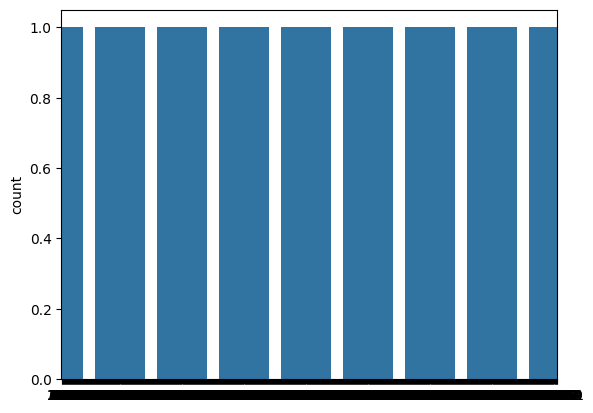

In [28]:
sns.countplot(new_dataset['Class'])

In [29]:
#splitting data into features and targets
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [30]:
print(X)

            Time        V1        V2        V3        V4        V5        V6  \
122731   76665.0 -0.970676  1.289379  1.054919 -0.008955 -1.245128 -1.085289   
18314    29376.0  1.073751 -0.228508 -0.317780 -0.245495  0.008571 -0.407715   
242285  151424.0 -0.598605  1.282699 -0.308352 -0.562917  0.733795 -0.632448   
276700  167252.0 -4.629842  1.881016 -0.154227  0.622789 -1.832261  0.738526   
244559  152404.0 -0.436761  1.062847 -0.109937 -0.512974  0.687294 -1.426479   
...          ...       ...       ...       ...       ...       ...       ...   
279863  169142.0 -1.927883  1.125653 -4.518331  1.749293 -1.566487 -2.010494   
280143  169347.0  1.378559  1.289381 -5.004247  1.411850  0.442581 -1.326536   
280149  169351.0 -0.676143  1.126366 -2.213700  0.468308 -1.120541 -0.003346   
281144  169966.0 -3.113832  0.585864 -5.399730  1.817092 -0.840618 -2.943548   
281674  170348.0  1.991976  0.158476 -2.583441  0.408670  1.151147 -0.096695   

              V7        V8        V9  .

In [31]:
print(Y)

122731    0
18314     0
242285    0
276700    0
244559    0
         ..
279863    1
280143    1
280149    1
281144    1
281674    1
Name: Class, Length: 984, dtype: int64


In [32]:
#split data into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=2)

In [33]:
print(X.shape, X_train.shape, X_test.shape)

(984, 30) (787, 30) (197, 30)


In [34]:
#model training
model = LogisticRegression()


In [35]:
model.fit(X_train, Y_train)

LogisticRegression()

In [36]:
#evaluation of model performance based on accuracy score
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [37]:
print('Accuracy on training data: ',training_data_accuracy )

Accuracy on training data:  0.9250317662007624


In [38]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [39]:
print('Accuracy on test data: ',test_data_accuracy )

Accuracy on test data:  0.9187817258883249


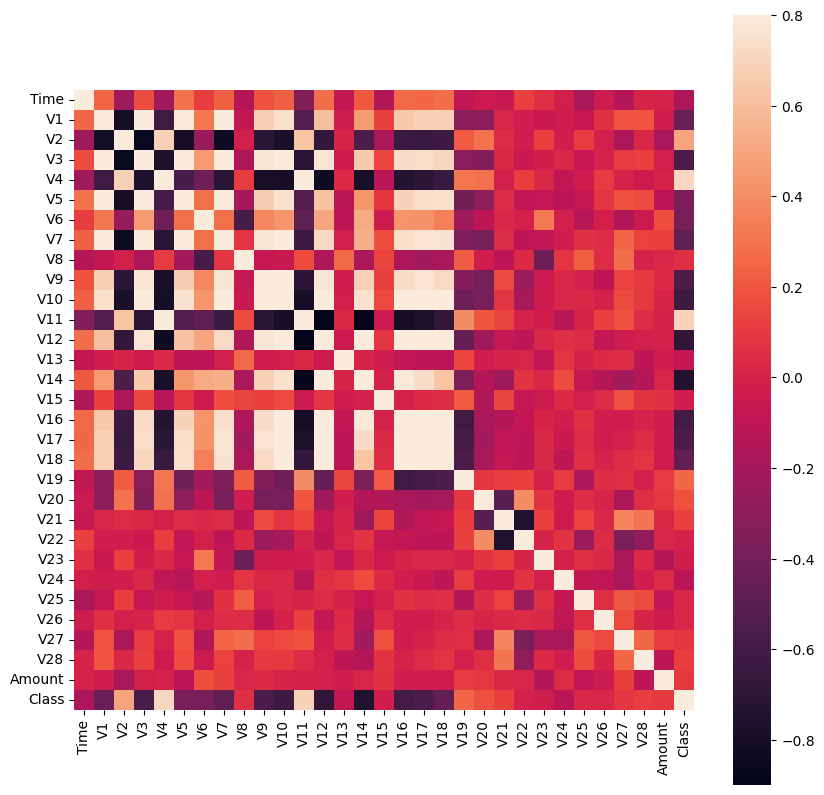

In [43]:
corrmat = new_dataset.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat , vmax=0.8 , square=True)
plt.show()

In [52]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 641 , random_state=0)
classifier.fit(X_train , Y_train)

RandomForestClassifier(n_estimators=641, random_state=0)

0.9238578680203046


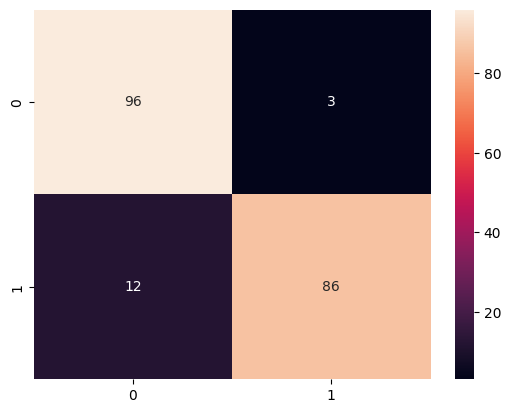

In [54]:
from sklearn.metrics import confusion_matrix , accuracy_score
cm = confusion_matrix(Y_test ,classifier.predict(X_test) )
sns.heatmap(cm , annot=True)
print(accuracy_score(Y_test , classifier.predict(X_test)))

In [55]:
from sklearn.metrics import classification_report
print(classification_report(Y_test ,classifier.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        99
           1       0.97      0.88      0.92        98

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197

